## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


## Camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ipywidgets import interact
import matplotlib.image as mpimg

%matplotlib inline

plt.rcParams['figure.figsize'] = [10,6]

In [2]:
def display_images_compare(images_a, images_b):
    #display images
    ncols = 2
    nrows = len(images_a)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    fig.tight_layout()

    count = 0
    for i in range(nrows):
            axes[i][0].imshow(images_a[count])
            axes[i][1].imshow(images_b[count], cmap='gray')
            count += 1

### Compute object and image points 

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

processed_images = []
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        processed_images.append(img)     



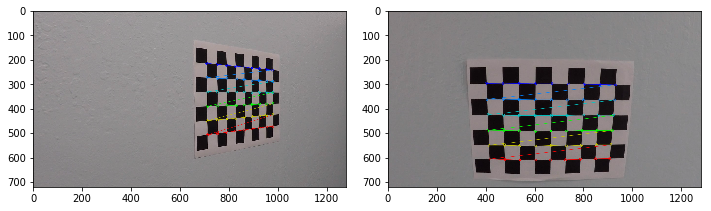

In [4]:
 #display images
ncols = 2
nrows = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
fig.tight_layout()

axes[0].imshow(processed_images[0])
axes[1].imshow(processed_images[1])      
plt.show()

### Calibrate Camera

In [5]:
#Calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [6]:
def undistort(image):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [7]:
def bgr2rgb(image):
    return image[...,::-1]

In [8]:
#undistort test images
test_images = glob.glob('test_images/*.jpg')
original_test_images = []
undistorted_test_images = []
for fname in test_images:
    img = cv2.imread(fname)
    img = bgr2rgb(img)
    original_test_images.append(img)
    undistorted_test_images.append(undistort(img))    

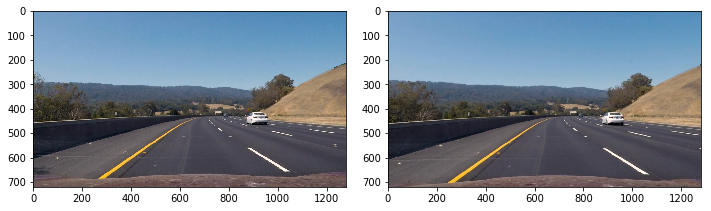

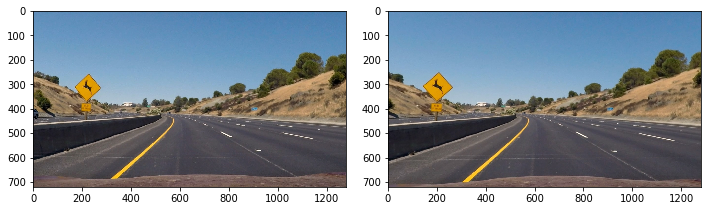

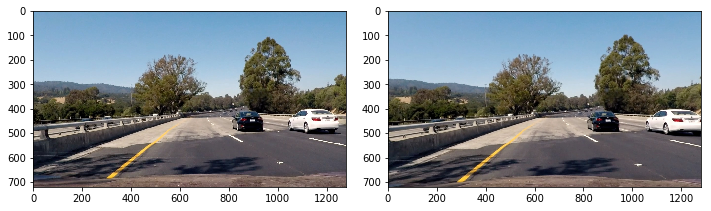

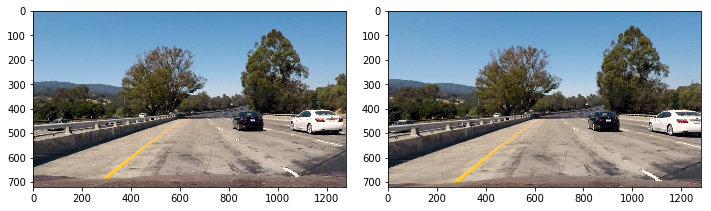

In [9]:
for original, undistorted in zip(original_test_images[:4], undistorted_test_images[:4]):
    ncols = 2
    nrows = 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    fig.tight_layout()

    axes[0].imshow(original)
    axes[1].imshow(undistorted)      
    plt.show()

## Thresholded Binary Image

### Gradient Threshold

In [10]:
#The function takes in an RGB image, gradient orientation, and threshold min / max values.
# Returns thresholded image
def abs_sobel_threshold(img, orient='x', sobel_kernel=3, thresh = (0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

In [11]:
# The function returns the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [12]:
# The function thresholds an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [13]:
def combined_threshold(image, kernel_size=3, 
                       x_thresh=(0,255), 
                       y_thresh=(0,255), 
                       mag_thresh=(0,255), 
                       dir_thresh=(0, np.pi/2)):
    gradx = abs_sobel_threshold(image, orient='x', sobel_kernel=kernel_size, thresh=x_thresh)
    grady = abs_sobel_threshold(image, orient='y', sobel_kernel=kernel_size, thresh=y_thresh)
    mag_binary = mag_threshold(image, sobel_kernel=ksize, mag_thresh=mag_thresh)
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=dir_thresh)
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined
    

In [14]:
grad_thresholded_imgs = []
for image in undistorted_test_images:        
    #thresh_img = combined_threshold(image, kernel_size=15, x_thresh=(30,100), y_thresh=(50,130), 
    #                                mag_thresh=(30,100), dir_thresh=(0.9, 1.1))
    thresh_img = abs_sobel_threshold(image, sobel_kernel=21, thresh=(30,130))
    
    grad_thresholded_imgs.append(thresh_img)    

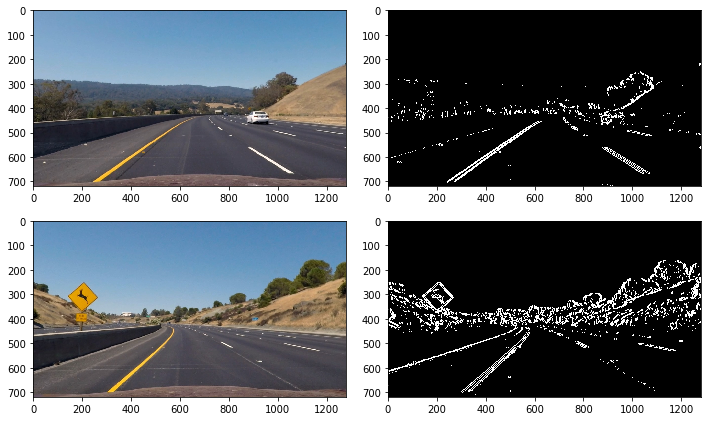

In [15]:
display_images_compare(undistorted_test_images[:2], grad_thresholded_imgs[:2])

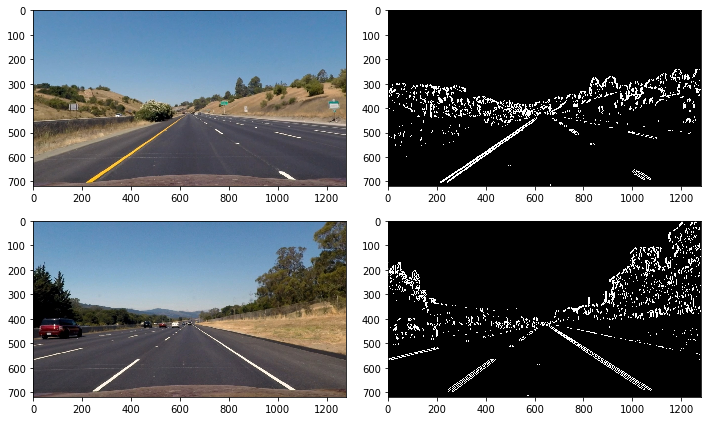

In [16]:
display_images_compare(undistorted_test_images[4:6], grad_thresholded_imgs[4:6])

### Color Threshold

In [17]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

In [18]:
color_thresholded_imgs = []
for image in undistorted_test_images:        
    thresh_img = hls_select(image, thresh=(170,255))
    color_thresholded_imgs.append(thresh_img)    

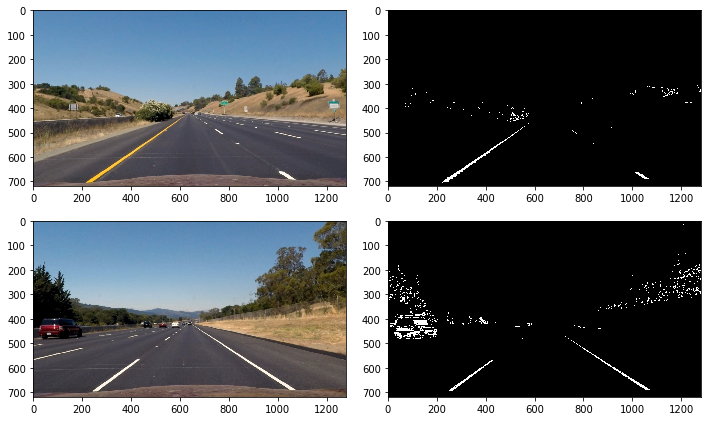

In [19]:
display_images_compare(undistorted_test_images[4:6], color_thresholded_imgs[4:6])

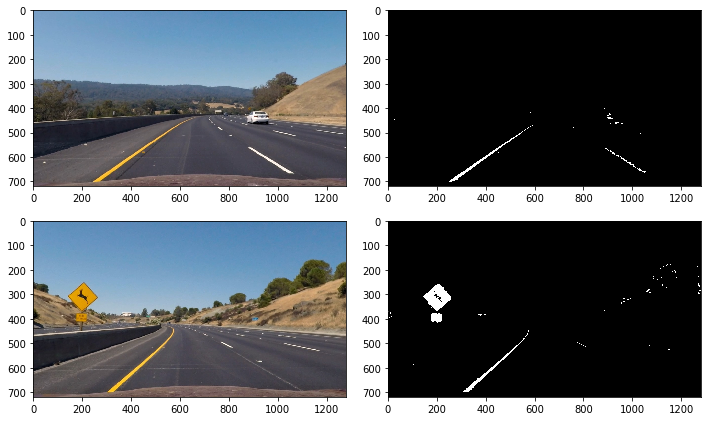

In [20]:
display_images_compare(undistorted_test_images[0:2], color_thresholded_imgs[0:2])

### Combine Color and Gradient Thresholds

In [21]:
color_binary_imgs = []
combined_binary_imgs = []
# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
for grad, color in zip(grad_thresholded_imgs, color_thresholded_imgs):
    
    color_binary = np.dstack(( np.zeros_like(grad), grad, color)) * 255
    color_binary_imgs.append(color_binary)

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(grad)
    combined_binary[(grad == 1) | (color == 1)] = 1

    combined_binary_imgs.append(combined_binary)   


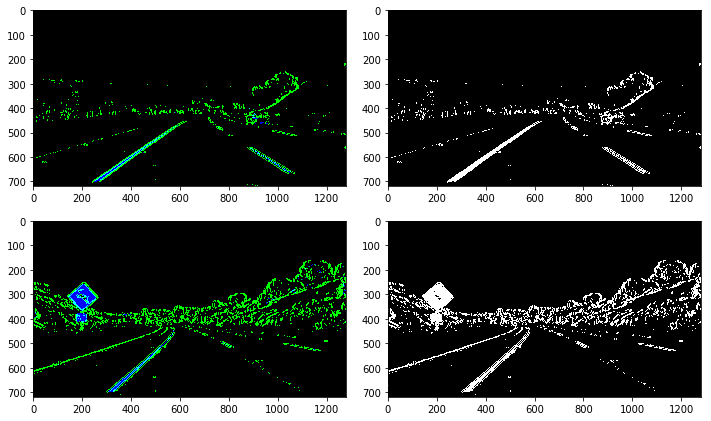

In [22]:
display_images_compare(color_binary_imgs[0:2], combined_binary_imgs[0:2])

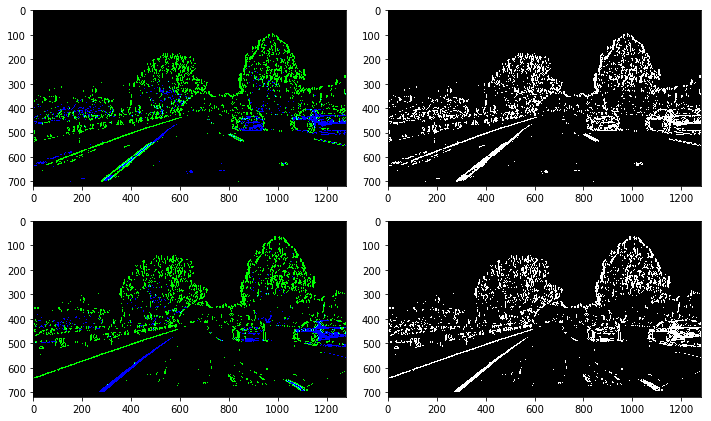

In [23]:
display_images_compare(color_binary_imgs[2:4], combined_binary_imgs[2:4])

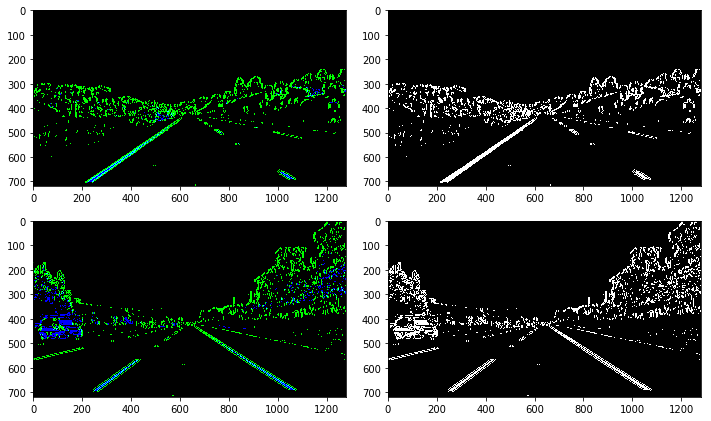

In [24]:
display_images_compare(color_binary_imgs[4:6], combined_binary_imgs[4:6])

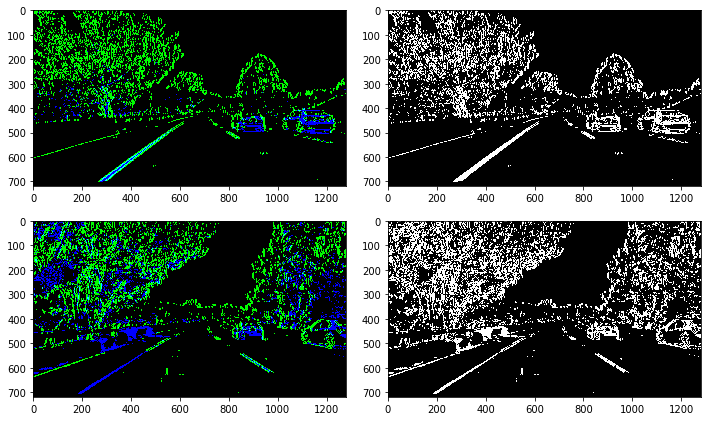

In [25]:
display_images_compare(color_binary_imgs[6:8], combined_binary_imgs[6:8])

## Perspective Transform

### Find trapezoid coordinates

In [26]:
#find source points on straight images
straight_images = glob.glob('test_images/straight*.jpg')
processed_straight_images = []
for fname in straight_images:
    img = cv2.imread(fname)
    img = bgr2rgb(img)
    processed_straight_images.append(img)    

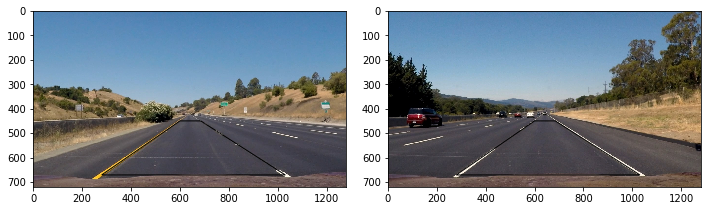

In [27]:
plt.rcParams['figure.figsize'] = [10,6]
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.tight_layout()
    
# Trapezoid
x = [280,600,685,1031]
y = [671,450,450,671]

# Display the image
axes[0].imshow(processed_straight_images[0])
axes[1].imshow(processed_straight_images[1])

axes[0].add_patch(patches.Polygon(xy=list(zip(x,y)), fill=False))
axes[1].add_patch(patches.Polygon(xy=list(zip(x,y)), fill=False))

plt.show()

### Compute Transform

In [28]:
src = np.float32([
    [280, 671],
    [600, 450],
    [685, 450],
    [1031, 671]
])

dst = np.float32([
    [280, 671],
    [280, 0],
    [1031, 0],
    [1031, 671]
])
    
perspective_transform = cv2.getPerspectiveTransform(src, dst)    
inverse_perspective_transform = cv2.getPerspectiveTransform(dst, src)

In [29]:
def get_warped(image):
    img_size = (image.shape[1], image.shape[0])    
    warped = cv2.warpPerspective(image, perspective_transform, img_size, flags=cv2.INTER_LINEAR)
    return warped

In [30]:
transformed_imgs = []
for image in combined_binary_imgs:
    transformed_imgs.append(get_warped(image))

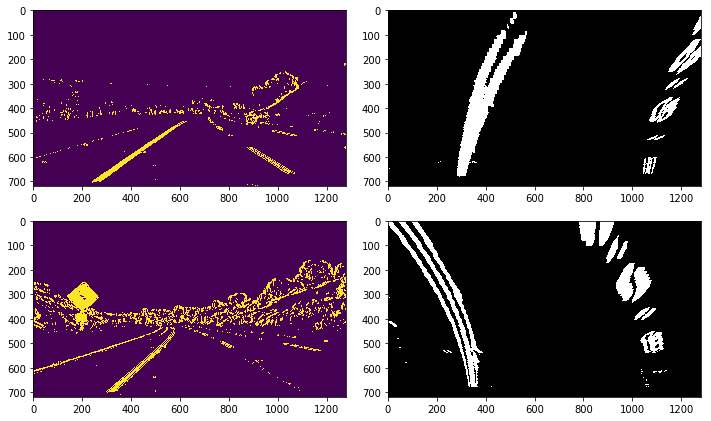

In [31]:
display_images_compare(combined_binary_imgs[0:2], transformed_imgs[0:2])

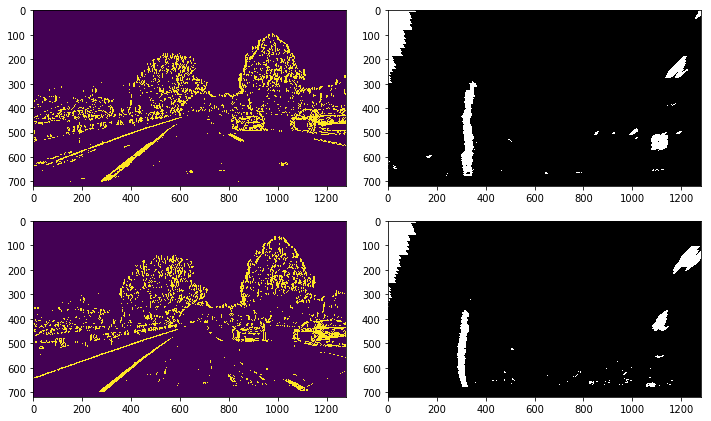

In [32]:
display_images_compare(combined_binary_imgs[2:4], transformed_imgs[2:4])

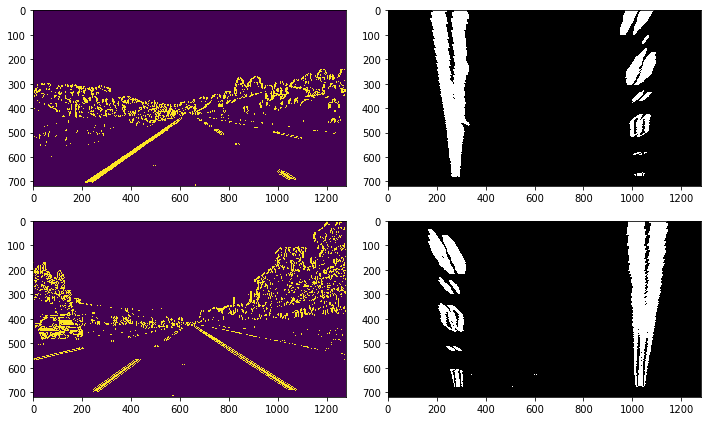

In [33]:
display_images_compare(combined_binary_imgs[4:6], transformed_imgs[4:6])

## Lanes Detection

### Convolutions

In [34]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

### Histogram Line Detection

In [47]:
#Processes the image and finds polynomials that fit the left and right lane
#Search the whole window
def find_lane_all_window(warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped, warped, warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, leftx, rightx, out_img

In [55]:
#Calculates curvature in meters
def find_radius_meters(ploty, left_fit, right_fit, leftx, rightx):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    y_eval = np.max(ploty)
    
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad   
    

In [49]:
def project_lines_and_data_on_image(original_image, warped, ploty, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    img_size = (original_image.shape[1], original_image.shape[0])    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inverse_perspective_transform, img_size) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)
    return result

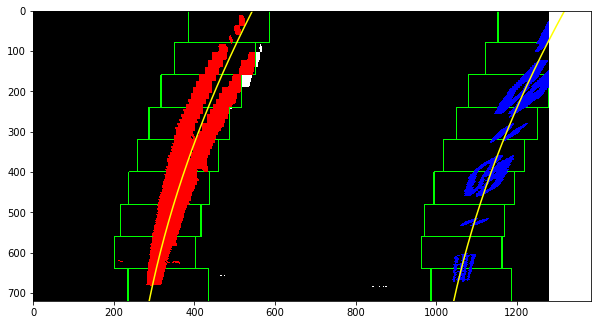

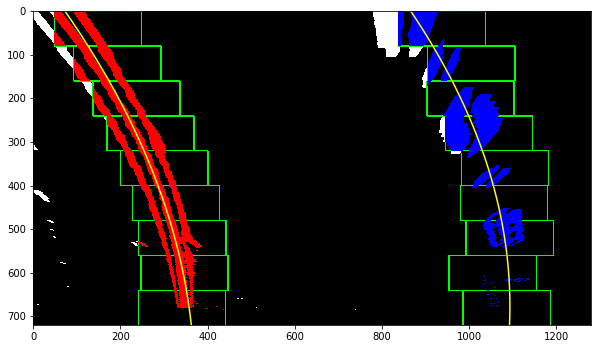

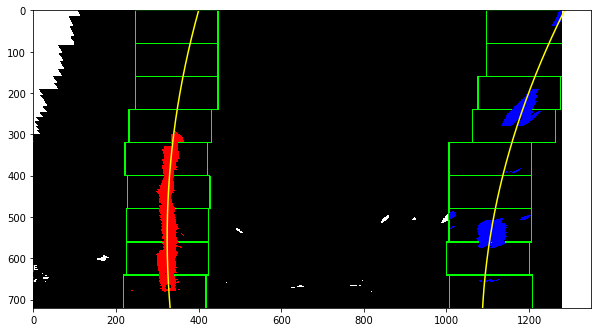

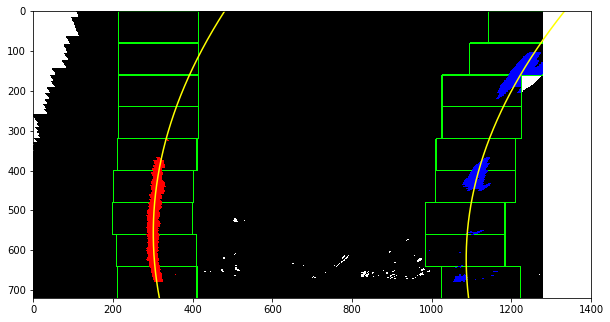

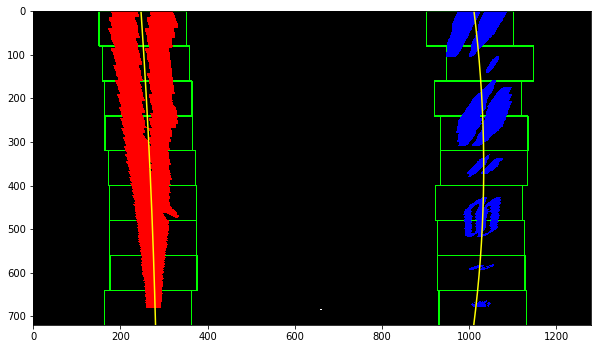

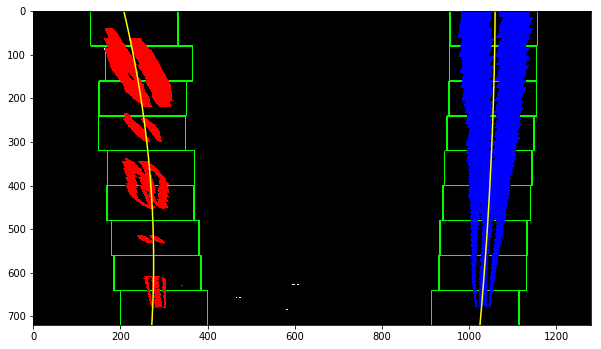

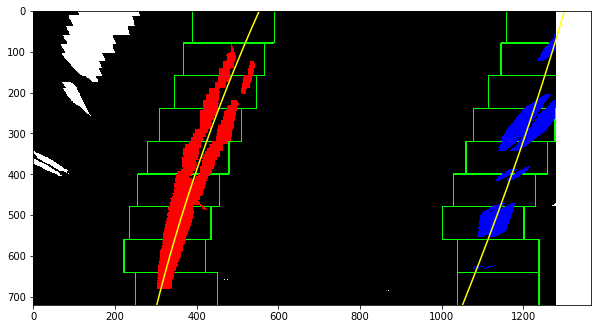

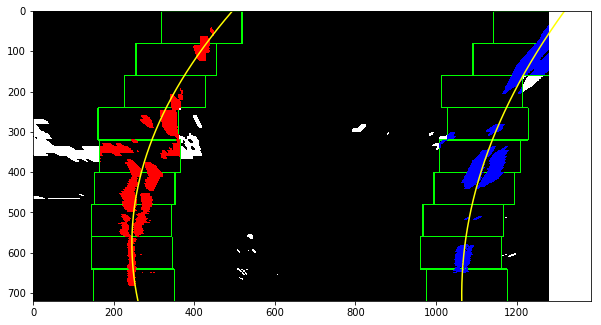

In [59]:
#perform search across all windows
for warped in transformed_imgs:
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    
    left_fit_all, right_fit_all, left_x_all, right_x_all, res_img = find_lane_all_window(warped)    
    left_fitx_all = left_fit_all[0]*ploty**2 + left_fit_all[1]*ploty + left_fit_all[2]
    right_fitx_all = right_fit_all[0]*ploty**2 + right_fit_all[1]*ploty + right_fit_all[2]
    
    plt.imshow(res_img)    
    plt.plot(left_fitx_all, ploty, color='yellow')
    plt.plot(right_fitx_all, ploty, color='yellow')
    
    #left_curverad, right_curverad = find_radius_meters(ploty, left_fit_all, right_fit_all, left_x_all, right_x_all)
    #print(left_curverad, 'm', right_curverad, 'm')
    
    plt.show()  

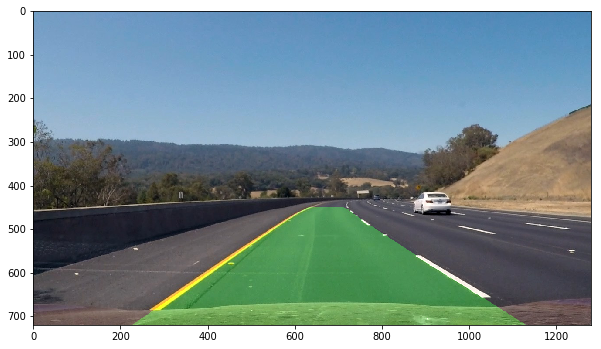

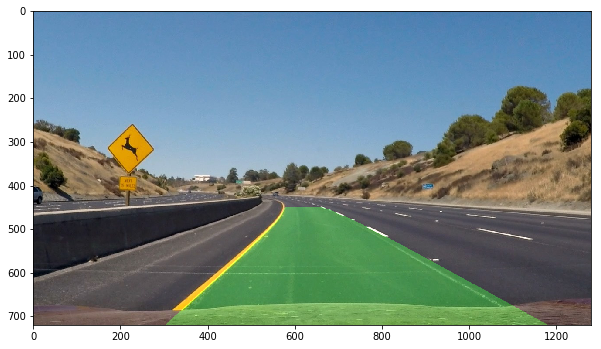

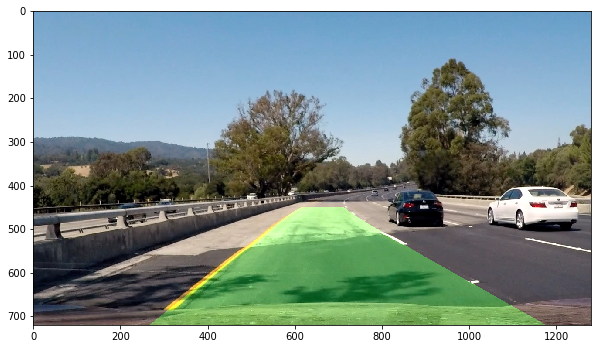

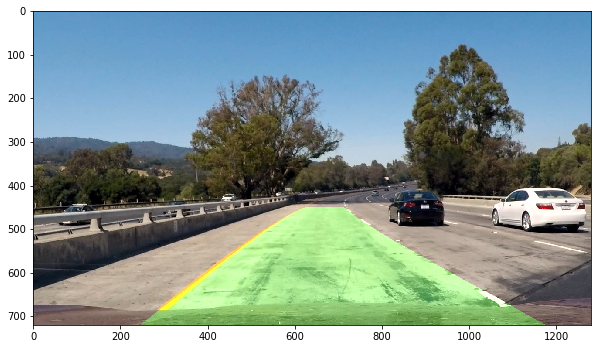

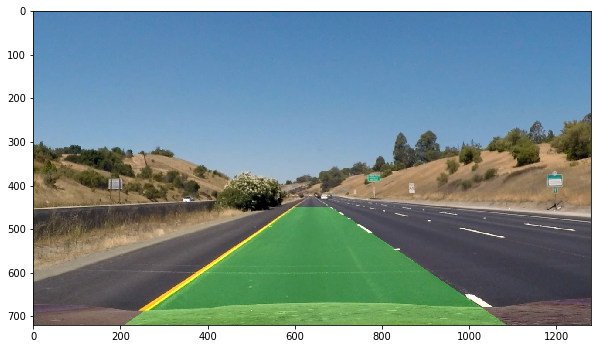

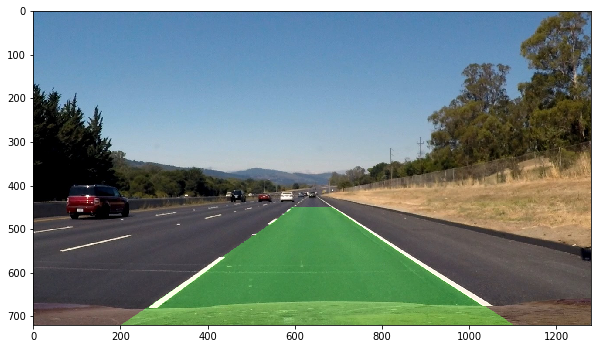

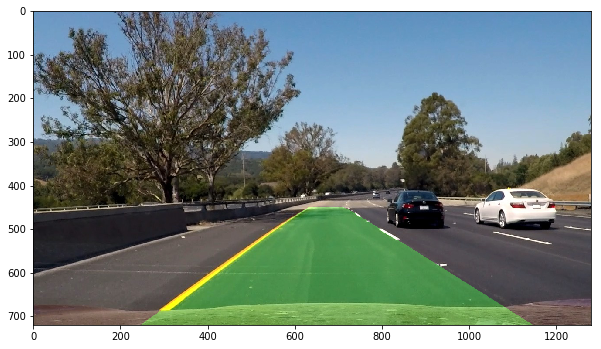

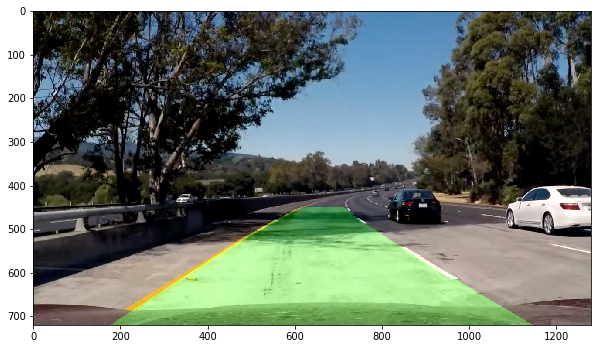

In [61]:
#perform search across all windows
for original, warped in zip(original_test_images, transformed_imgs):
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    
    left_fit, right_fit, left_x, right_x, res_img = find_lane_all_window(warped)    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    img = project_lines_and_data_on_image(original, warped, ploty, left_fitx, right_fitx)
    plt.imshow(img)
    plt.show()

In [57]:
#finds lane from the previous position
def find_lane_previous_position(warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)    
    right_fit = np.polyfit(righty, rightx, 2)
        
    #visualize
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped, warped, warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return left_fit, right_fit, leftx, rightx, result

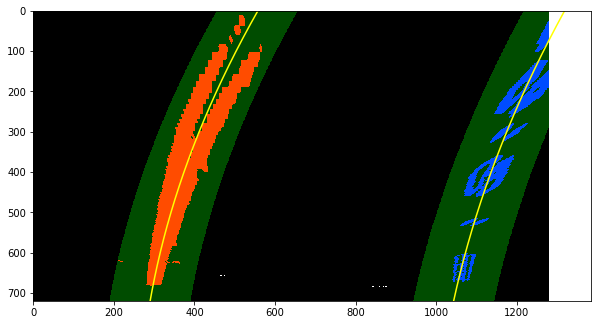

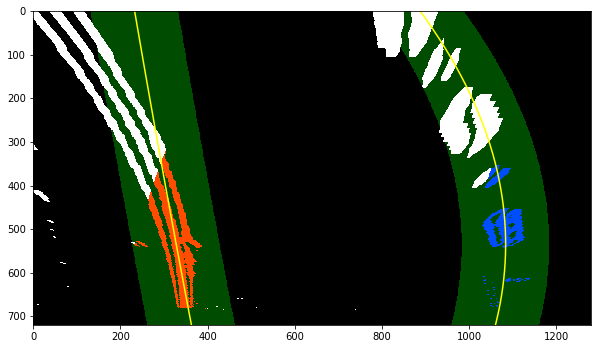

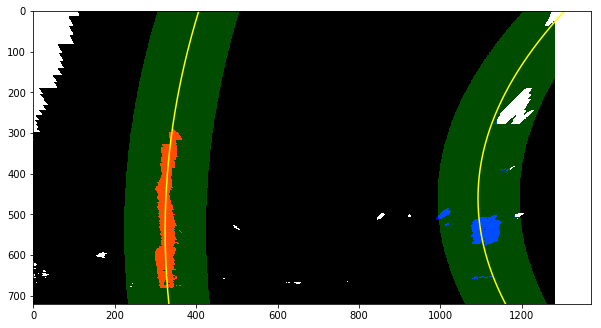

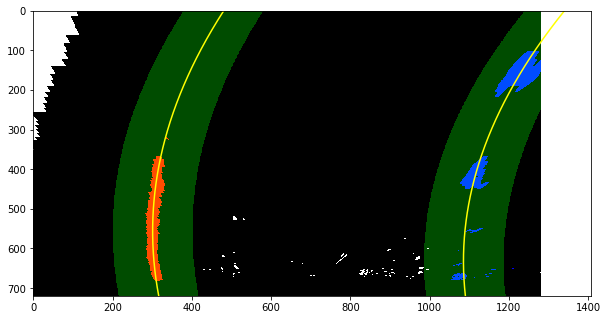

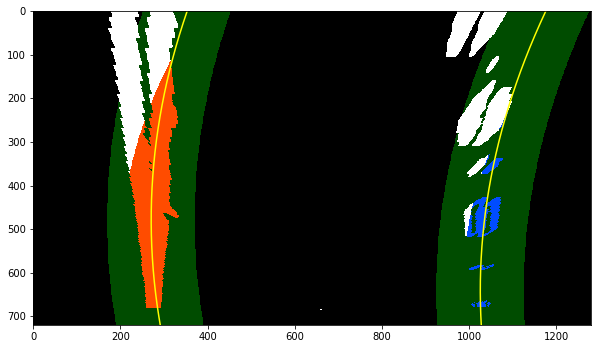

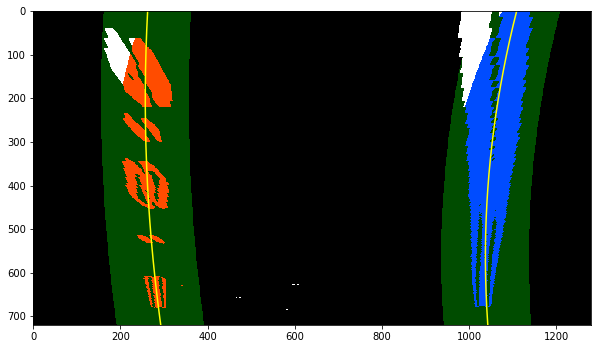

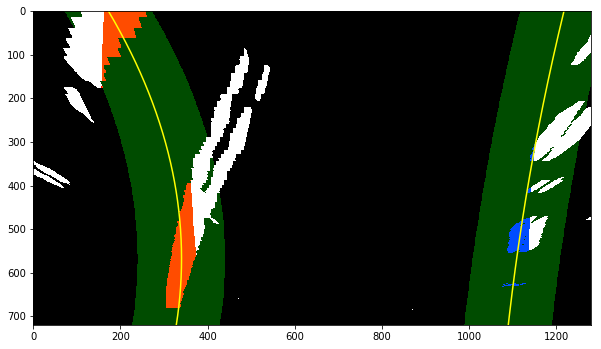

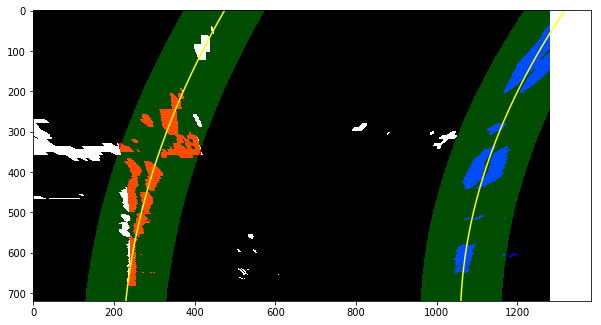

In [58]:
#search in previous shape
left_fit_prev, right_fit_prev = None, None

for warped in transformed_imgs:
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    
    if left_fit_prev is None and right_fit_prev is None: 
        left_fit_all, right_fit_all, left_x_all, right_x_all, res_img = find_lane_all_window(warped)    
        left_fit_prev = left_fit_all
        right_fit_prev = right_fit_all
    
        
    left_fit_prev, right_fit_prev, left_x_prev, right_x_prev, res_img2 = find_lane_previous_position(warped, left_fit_prev, right_fit_prev)    
    left_fitx_prev = left_fit_prev[0]*ploty**2 + left_fit_prev[1]*ploty + left_fit_prev[2]
    right_fitx_prev = right_fit_prev[0]*ploty**2 + right_fit_prev[1]*ploty + right_fit_prev[2]
    
#    left_curverad, right_curverad = find_radius_meters(ploty, left_x_prev, right_x_prev)
#    print(left_curverad, 'm', right_curverad, 'm')
    
    plt.imshow(res_img2)
    plt.plot(left_fitx_prev, ploty, color='yellow')
    plt.plot(right_fitx_prev, ploty, color='yellow')
    
    plt.show()  